In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from kneed.knee_locator import KneeLocator

# HOW CAN ADULTS SUFFERING FROM DEPRESSION BE CLUSTERED?
<img src="ethan-sykes-TdM_fhzmWog-unsplash.jpg" width="50%" />
Photo by <a href="https://unsplash.com/@e_sykes?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ethan Sykes</a> on <a href="https://unsplash.com/s/photos/depressed?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

# Table of Contents

* [Introduction](#introduction)
* [Research Question](#hypothesis)
* [Data](#data)
* [Methods](#methods)
* [Results](#results)
* [Discussion and Recommendations](#discussion)
* [References](#references)
* [Appendix](#appendix)

<a class="anchor" id="introduction"></a> 
# Introduction

At least 17 million adults in the US suffer from depression each year.<sup>[1](#references)</sup>  And, according to the NCBI article, <u>Depression: How effective are antidepressants?</u><sup>[2](#references)</sup>, only 40 to 60 percent of those with severe depression who take antidepressants notice an improvement in their symptoms.  In this project I would like to explore how adults suffering from depression can be clustered.  If a clear seperation of clusters can be found, tailored treatments can be created to better help those sufferening from depression.  This is a topic of personal interest as my husband suffers from chronic depression.

<a class="anchor" id="hypothesis"></a> 
# Research Question

How can adults suffering from depression be clustered?

<a class="anchor" id="data"></a> 
# Data



In order to answer this question, I am using data from the 2019 National Health Interview Survey, Sample Adult Interview.<sup>[3](#references)</sup> The National Health Intervey Survey is a yearly survey meant to 'monitor the health of the United States population.'<sup>[4](#references)</sup> It is a survey conducted in person throughout the year each year.  Populations not included in the survey: individuals with no fixed address, military personnel on active duty, people in long term care facilities, and US citizens living outside the US.  Due to this and the fact it is an optional survey, results are not completely representative of the entire US population.  

The 2019 survey comes in two forms: an adult interview and a child interview.  For the project I chose to use data from the adult interview.

Topics covered in the survey include but is not limited to: demographic data, chronic illnesses, mental health, health insurance coverage, substance use.

In [2]:
df = pd.read_csv('data/adult19.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31997 entries, 0 to 31996
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 130.4+ MB


The dataset consists of 31,996 observations and 534 features.  The features I plan to use are listed below.  After going through the entire codebook I chose to use only questions related to depression, demographics, chronic conditions, and substance abuse as I felt all might impact depression the most and have the fewest missing values.

In [3]:
variables_df = pd.read_csv('vars.csv')
variables_df

,Variable,Question/Description,Category
0,DEPEV_A,Ever had depression,depression
1,DEPFREQ_A,How often depressed,depression
2,DEPMED_A,Take medication for depression,depression
3,DEPLEVEL_A,Level of how depressed,depression
4,PHQ81_A,How often little interest in things past 2 weeks,depression
5,PHQ82_A,How often feeling down past 2 weeks,depression
6,PHQ83_A,How often trouble with sleeping past 2 weeks,depression
7,PHQ84_A,How often feeling tired past 2 weeks,depression
8,PHQ85_A,How often undereating or overeating past 2 weeks,depression
9,PHQ86_A,How often feeling bad about self past 2 weeks,depression


For the project, I decided to choose only the observations in which the person feels depression at least on a weekly basis.

In [4]:
# for the above go into why you chose that give a reference to the definition of depression.

In [5]:
df_depressed = df[variables_df.Variable][df.DEPFREQ_A <= 2].copy()

In [6]:
df_depressed.head()

,DEPEV_A,DEPFREQ_A,DEPMED_A,DEPLEVEL_A,PHQ81_A,PHQ82_A,PHQ83_A,PHQ84_A,PHQ85_A,PHQ86_A,...,HISP_A,OPD12M_A,SMKNOW_A,ECIGNOW_A,HYPEV_A,CHLEV_A,ASEV_A,CANEV_A,DIBEV_A,COPDEV_A
4,1,1,1,3.0,4,3,2,3,2,2,...,2,2.0,1.0,NaN,1,1,1,2,1,1
28,2,2,2,3.0,1,3,3,1,2,3,...,2,NaN,1.0,3.0,2,2,2,2,2,2
37,1,1,1,3.0,1,3,4,2,1,2,...,2,2.0,1.0,NaN,1,2,2,2,2,2
41,2,2,2,3.0,2,3,4,4,4,4,...,2,2.0,NaN,NaN,2,2,2,2,2,2
48,1,1,2,1.0,1,2,1,1,2,1,...,1,2.0,3.0,1.0,1,1,1,1,2,2


## Checking for null values

In [7]:
df_depressed.isnull().sum()

DEPEV_A            0
DEPFREQ_A          0
DEPMED_A           0
DEPLEVEL_A         0
PHQ81_A            0
PHQ82_A            0
PHQ83_A            0
PHQ84_A            0
PHQ85_A            0
PHQ86_A            0
PHQ87_A            0
PHQ88_A            0
AGEP_A             0
SEX_A              0
MARITAL_A          0
FAMINCTC_A         0
EDUC_A             0
EMPWRKLSWK_A       0
RACEALLP_A         0
HISP_A             0
OPD12M_A         452
SMKNOW_A        1481
ECIGNOW_A       2310
HYPEV_A            0
CHLEV_A            0
ASEV_A             0
CANEV_A            0
DIBEV_A            0
COPDEV_A           0
dtype: int64

Since more than a third of the observations have missing values for variables SMKNOW_A and ECIGNOW_A, I am going to drop the variables having to do with substance use.

In [8]:
df_depressed.drop(['OPD12M_A','SMKNOW_A','ECIGNOW_A'],axis=1,inplace=True)

In the methods section below, I mention I split the dataset into three subsets: one containing the variables related to depression, one containing the demographic variables, and one pertaining to chronic conditions.

In [9]:
depressed_vars = variables_df[variables_df["Category"]=="depression"]["Variable"]
df_depressed_core = df_depressed[depressed_vars].copy()
demo_vars = variables_df[variables_df["Category"]=="demographics"]["Variable"]
df_demo = df_depressed[demo_vars].copy()
cc_vars = variables_df[variables_df["Category"]=="chronic_conditions"]["Variable"]
df_cc = df_depressed[cc_vars].copy()

For visualizations, numerical values will be replaced with their labels as found in the codebook.

In [10]:
yes_no_labels = {1:'Yes',2:'No',7:'Refused',8:'Not ascertained',9:"Don't know"}
freq_labels = {1:'Daily',2:'Weekly'}
lvl_labels = {1: 'A little', 2: 'A lot', 3 : 'Somewhere in between',7:'Refused',8:'Not ascertained',9:"Don't know"}
phq_labels = {1:'Not at all',2:'Several days',3:'More than half the days',4:'Nearly every day',
              7:'Refused',8:'Not ascertained',9:"Don't know"}
# need to do demo & cc labels

In [11]:
df_depressed_core['DEPEV_A'].replace(yes_no_labels,inplace=True)
df_depressed_core['DEPMED_A'].replace(yes_no_labels,inplace=True)
df_depressed_core['DEPFREQ_A'].replace(freq_labels, inplace=True)
df_depressed_core['DEPLEVEL_A'].replace(lvl_labels, inplace=True)
for var in ['PHQ81_A','PHQ82_A','PHQ83_A','PHQ84_A','PHQ85_A','PHQ86_A','PHQ87_A','PHQ88_A']:
    df_depressed_core[var].replace(phq_labels,inplace=True)


The exploratory data analysis can be found in the [appendix](#appendix). 

<a class="anchor" id="methods"></a> 
# Methods

The algoritms I plan to use to cluster the data are
* Kmeans clustering
* DBSCAN clustering

Hierarchal clustering and Gauusian mixture models will not be used as the number of clusters needs to be known in advance.  With kmeans, this can be determined using inertia.  It would be intersting to explore Hierarchal clustering and Gaussian mixture models in the future.

Silhouette score will be used to evaluate the clustering and determine the best clustering.

I plan to first cluster with only the data with questions regarding depression and then add variables having to do with demographics and chronic conditions

## Subsets of data to be clustered
* Depression data
* Depression data + demographic data
* Depression data + data on chronic conditions
* Depression data + demographic data + data on chronic conditions


## Data preparation

<a class="anchor" id="results"></a> 
# Results

Now, you can walk through the results of the methods. State the results of your tests and explain whether these results mean that you reject or fail to reject the null. Also include compelling tables or graphs to illustrate your findings.

<a class="anchor" id="discussion"></a> 
# Discussion and Recommendations

What insights can interested parties get from this research? What would you recommend for further research?

<a class="anchor" id="references"></a>   
# References

1. National Institute of Mental Health. Major Depression. https://www.nimh.nih.gov/health/statistics/major-depression

2. InformedHealth.org [Internet]. Cologne, Germany: Institute for Quality and Efficiency in Health Care (IQWiG); 2006-. Depression: How effective are antidepressants? [Updated 2020 Jun 18]. Available from: https://www.ncbi.nlm.nih.gov/books/NBK361016/

3. National Center for Health Statistics. (April 5, 2021) National Health Interview Survey. https://www.cdc.gov/nchs/nhis/2019nhis.htm

4. National Center for Health Statistics. (September 16, 2020). About the National Health Interview Survey. https://www.cdc.gov/nchs/nhis/about_nhis.htm

Sharma, A. (2020, September 8) How to Master the Popular DBSCAN Clustering Algorithm for Machine Learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

Mullin, T. (2020, July 9) DBSCAN Parameter Estimation Using Python.  Medium. https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

Erich Schubert, Jörg Sander, Martin Ester, Hans-Peter Kriegel, and Xiaowei Xu. 2017. DBSCAN Revisited,
Revisited: Why and How You Should (Still) Use DBSCAN. ACM Trans. Database Syst. 42, 3, Article 19 (July
2017), 21 pages.
https://doi.org/10.1145/3068335



<a class="anchor" id="appendix"></a> 
# Appendix

## Exploratory data analysis

### Depression variables

In [12]:
df_depressed_core.head()

,DEPEV_A,DEPFREQ_A,DEPMED_A,DEPLEVEL_A,PHQ81_A,PHQ82_A,PHQ83_A,PHQ84_A,PHQ85_A,PHQ86_A,PHQ87_A,PHQ88_A
4,Yes,Daily,Yes,Somewhere in between,Nearly every day,More than half the days,Several days,More than half the days,Several days,Several days,Nearly every day,Not at all
28,No,Weekly,No,Somewhere in between,Not at all,More than half the days,More than half the days,Not at all,Several days,More than half the days,Not at all,Not at all
37,Yes,Daily,Yes,Somewhere in between,Not at all,More than half the days,Nearly every day,Several days,Not at all,Several days,Not at all,Not at all
41,No,Weekly,No,Somewhere in between,Several days,More than half the days,Nearly every day,Nearly every day,Nearly every day,Nearly every day,Nearly every day,Not at all
48,Yes,Daily,No,A little,Not at all,Several days,Not at all,Not at all,Several days,Not at all,Nearly every day,Not at all


#### DEPEV_A

According to the codebook, DEPEV_A is the response to the question: "Have you ever been told by a doctor or health professional that you had ...any type of depression?"

<AxesSubplot:xlabel='DEPEV_A', ylabel='count'>

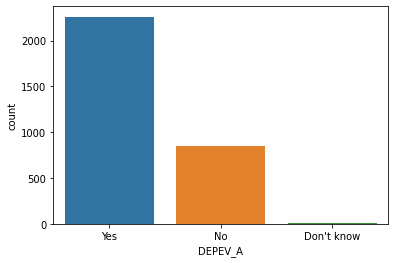

In [13]:
sns.countplot(x='DEPEV_A',data=df_depressed_core)

The majority that feel depression on a weekly or daily basis have been told by a doctor they do have depression.

#### DEPFREQ_A

DEPFREQ_A is the response to the question, "how often do you feel depressed?"

<AxesSubplot:xlabel='DEPFREQ_A', ylabel='count'>

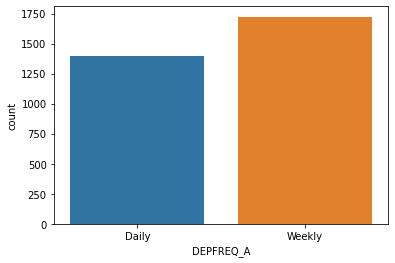

In [14]:
sns.countplot(x='DEPFREQ_A', data=df_depressed_core)

As seen above, a little more than half of the people feel depressed on a weekly basis.

#### DEPMED_A

DEPMED_A represents responces to the question, "Do you take prescription medication for depression?"



<AxesSubplot:xlabel='DEPMED_A', ylabel='count'>

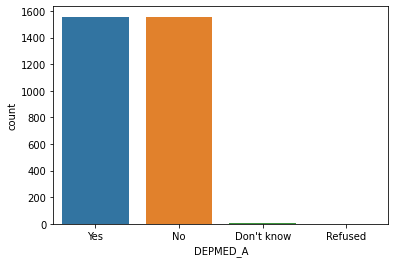

In [15]:
sns.countplot(x='DEPMED_A',data=df_depressed_core)

Approximately half of the respondents do take medication.  It would be intererested to explore the relationship between levels of depression and DEPMED_A as well as exploring medical insurance variables for those whom do not take medication. 

#### DEPLEVEL_A

DEPLEVEL_A is the respondent's answer to the question, "Thinking about the last time you felt depressed, how depressed did you feel?  Would you say a little, a lot, or somewhere in between?"

<AxesSubplot:xlabel='DEPLEVEL_A', ylabel='count'>

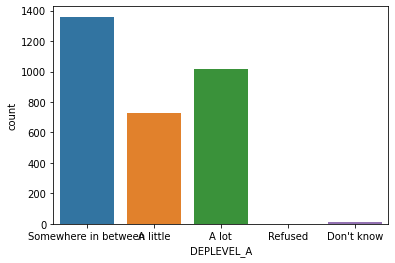

In [16]:
sns.countplot(x='DEPLEVEL_A', data=df_depressed_core)

Most people feeling depressed on a daily or weekly basis said they feel somewhere in between a little and a lot depressed.